# Towards efficient automatic water meter reading using haar-like features.

This project aims to automate water meter reading with the use of haar like features. The first step uses a segmentation model with water meter images and its corrresponfing masks to extract the water meter reading region. Thereafter the regions are further processed by rotating, reszing and croppping. The cropped images are used to extract the digit regions using bounding boxes and masks created from them. The regions are labeled with the correct digit value. Each region is thn convered to and integral image and haar features are extracted from each of them. The haar feature vectores are stored in a csv file with its correct label digit values. Therafter this data is used in an Adaboost classifier to predict the digit values based on the haar features for the different regions for a given water meter image.


# Data analysis

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
#Import Relevant Libraries
import re, cv2, os, json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageOps
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import decimal
import shutil

In [33]:
%%writefile skip_kernel_extension.py
def skip(line, cell=None):
    '''Skips execution of the current line/cell if line evaluates to True.'''
    if eval(line):
        return

    get_ipython().ex(cell)

def load_ipython_extension(shell):
    '''Registers the skip magic when the extension loads.'''
    shell.register_magic_function(skip, 'line_cell')

def unload_ipython_extension(shell):
    '''Unregisters the skip magic when the extension unloads.'''
    del shell.magics_manager.magics['cell']['skip']

Writing skip_kernel_extension.py


In [34]:
%load_ext skip_kernel_extension

In [35]:
!pip install -q kaggle

In [40]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"thamaineg","key":"aa03dcd9c24cf7ab1f380771bdb1c113"}'}

In [41]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [42]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [44]:
!kaggle datasets download -d tapakah68/yandextoloka-water-meters-dataset

 98% 963M/982M [00:12<00:00, 149MB/s]
100% 982M/982M [00:12<00:00, 79.7MB/s]


In [45]:
!unzip  yandextoloka-water-meters-dataset.zip

Archive:  yandextoloka-water-meters-dataset.zip
  inflating: WaterMeters/collage/id_1000_value_176_881.jpg  
  inflating: WaterMeters/collage/id_1001_value_1113_124.jpg  
  inflating: WaterMeters/collage/id_1002_value_105_174.jpg  
  inflating: WaterMeters/collage/id_1003_value_209_317.jpg  
  inflating: WaterMeters/collage/id_1004_value_37_176.jpg  
  inflating: WaterMeters/collage/id_1005_value_273_47.jpg  
  inflating: WaterMeters/collage/id_1006_value_66_009.jpg  
  inflating: WaterMeters/collage/id_1007_value_60_219.jpg  
  inflating: WaterMeters/collage/id_1008_value_95_912.jpg  
  inflating: WaterMeters/collage/id_1009_value_133_679.jpg  
  inflating: WaterMeters/collage/id_100_value_51_256.jpg  
  inflating: WaterMeters/collage/id_1010_value_109_919.jpg  
  inflating: WaterMeters/collage/id_1011_value_567_0.jpg  
  inflating: WaterMeters/collage/id_1012_value_591_381.jpg  
  inflating: WaterMeters/collage/id_1013_value_797_523.jpg  
  inflating: WaterMeters/collage/id_1014_valu

In [46]:

#Load data and paths
data = '/content/WaterMeters/data.csv'

images_folder = "/content/WaterMeters/images"
masks_folder = "/content/WaterMeters/masks"
coll_folder = "/content/WaterMeters/collage"

In [47]:
import pandas as pd
import csv

url = '/content/WaterMeters/data.csv'
df = pd.read_csv(url)

df.head(10)

photo_name     value  \
0    id_53_value_595_825.jpg   595.825   
1    id_553_value_65_475.jpg    65.475   
2     id_407_value_21_86.jpg    21.860   
3   id_252_value_313_322.jpg   313.322   
4   id_851_value_305_162.jpg   305.162   
5     id_398_value_8_898.jpg     8.898   
6   id_1204_value_78_677.jpg    78.677   
7   id_83_value_1336_114.jpg  1336.114   
8  id_1061_value_572_883.jpg   572.883   
9     id_71_value_90_216.jpg    90.216   

                                            location  
0  {'type': 'polygon', 'data': [{'x': 0.30788, 'y...  
1  {'type': 'polygon', 'data': [{'x': 0.26133, 'y...  
2  {'type': 'polygon', 'data': [{'x': 0.27545, 'y...  
3  {'type': 'polygon', 'data': [{'x': 0.21967, 'y...  
4  {'type': 'polygon', 'data': [{'x': 0.06983, 'y...  
5  {'type': 'polygon', 'data': [{'x': 0.60781, 'y...  
6  {'type': 'polygon', 'data': [{'x': 0.26854, 'y...  
7  {'type': 'polygon', 'data': [{'x': 0.31447, 'y...  
8  {'type': 'polygon', 'data': [{'x': 0.14358, 'y...  
9  {'type': 'polygon', 'data': [{'x': 0.30247, 'y...

In [48]:
#Obtain a count of images, masks, and observations.
print(f'Total number of images: {len(os.listdir(images_folder))}')
print(f'Total number of image masks: {len(os.listdir(masks_folder))}')
print(f'Length of dataset: {len(data)}')

Total number of images: 1244
Total number of image masks: 1244
Length of dataset: 29


Printing water meter images

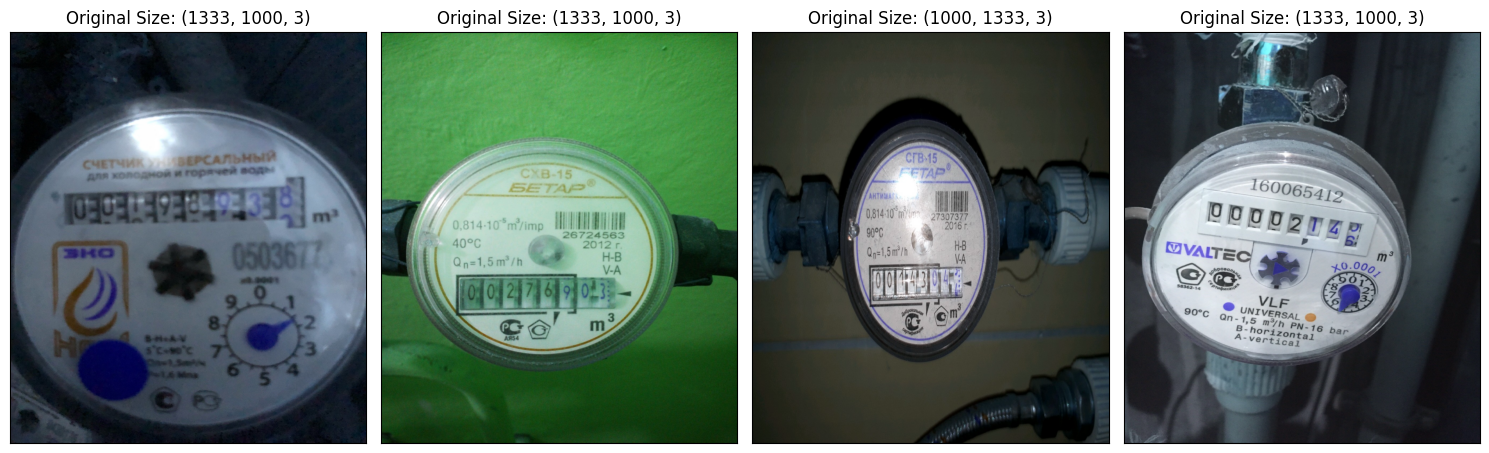

In [49]:
#Create figure and empty list for axes
axes=[]
fig=plt.figure(figsize=(15, 15))

#Show first 4 images in dataset with corresponding shape.
for a in range(4):
    #Obtain file name and create path.
    file = os.listdir("/content/WaterMeters/images")[a]
    image_path = os.path.join(images_folder, file)

    #Read the file image and resize it for show.
    img = cv2.imread(image_path)
    resized_image = cv2.resize(img, (1300, 1500), interpolation = cv2.INTER_AREA)

    #Print the resized image and dislpay the shape.
    axes.append(fig.add_subplot(1, 4, a+1) )
    subplot_title=(f"Original Size: {img.shape}")
    axes[-1].set_title(subplot_title)
    plt.imshow(resized_image)

#Remove ticks from each image.
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

#Plot the image.
fig.tight_layout()
plt.show()

Printing masks

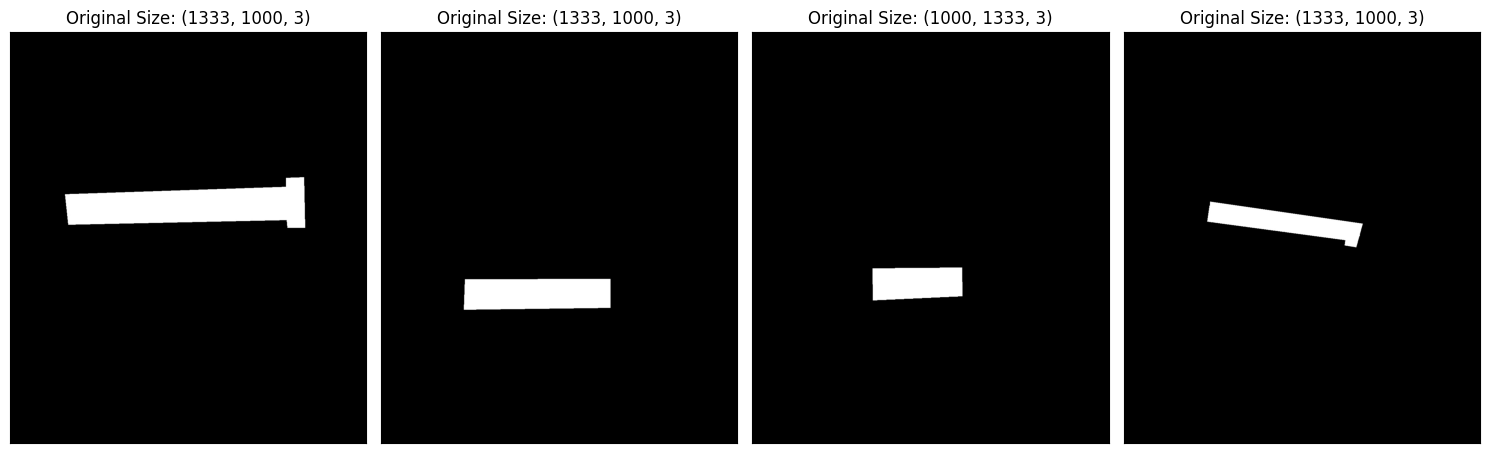

In [50]:
#Create figure and empty list for axes
axes=[]
fig=plt.figure(figsize=(15, 15))

#Show first 4 images in dataset with corresponding shape.
for a in range(4):
    #Obtain file name and create path.
    file = os.listdir("/content/WaterMeters/masks")[a]
    image_path = os.path.join(masks_folder, file)

    #Read the file image and resize it for show.
    img = cv2.imread(image_path)
    resized_image = cv2.resize(img, (1300, 1500), interpolation = cv2.INTER_AREA)

    #Print the resized image and dislpay the shape.
    axes.append(fig.add_subplot(1, 4, a+1) )
    subplot_title=(f"Original Size: {img.shape}")
    axes[-1].set_title(subplot_title)
    plt.imshow(resized_image)

#Remove ticks from each image.
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

#Plot the image.
fig.tight_layout()
plt.show()

In [51]:
import pandas as pd

# Assuming 'data' is a string representation of a DataFrame, you need to convert it to a DataFrame first
# For example, if 'data' is a CSV file path, you can read it into a DataFrame like this:
data = pd.read_csv('/content/WaterMeters/data.csv')

# Now, you can examine the head of the DataFrame
pd.set_option('display.max_colwidth', 70)
print(data.head())

                 photo_name    value  \
0   id_53_value_595_825.jpg  595.825   
1   id_553_value_65_475.jpg   65.475   
2    id_407_value_21_86.jpg   21.860   
3  id_252_value_313_322.jpg  313.322   
4  id_851_value_305_162.jpg  305.162   

                                                                location  
0  {'type': 'polygon', 'data': [{'x': 0.30788, 'y': 0.30207}, {'x': 0...  
1  {'type': 'polygon', 'data': [{'x': 0.26133, 'y': 0.24071}, {'x': 0...  
2  {'type': 'polygon', 'data': [{'x': 0.27545, 'y': 0.19134}, {'x': 0...  
3  {'type': 'polygon', 'data': [{'x': 0.21967, 'y': 0.50845}, {'x': 0...  
4  {'type': 'polygon', 'data': [{'x': 0.06983, 'y': 0.43491}, {'x': 0...  


In [52]:
#Create function to extract polygon locations from 'location' string.
def location_vals(obvs, x_or_y):
    '''
    Function uses regular expressions to parse the "location" string for each observation.
    Inputs are "obvs" and "x_or_y".

    obvs: This simply serves as the string being passed into the function.
    x_or_y: If "x" is entered, then the function extracts all "x" location values. If anything else, then it extracts "y" location values.
    '''
    if x_or_y == 'x':
        x = re.findall(r"\'x\': ([0-9.]*),", obvs)
        return x
    else:
        y = re.findall(r"\'y\': ([0-9.]*)}", obvs)
        return y

In [53]:
#Creat function to return image size.
def image_size(img_name):
    '''
    The image name from each observation serves as the input.
    The image is then read using cv2, and its shape is returned.
    '''
    image_path = os.path.join(images_folder, img_name)
    img = cv2.imread(image_path)
    return img.shape

#Apply function to each row of DataFrame.
data['shape'] = data['photo_name'].apply(image_size)
display(data.head())

photo_name    value  \
0   id_53_value_595_825.jpg  595.825   
1   id_553_value_65_475.jpg   65.475   
2    id_407_value_21_86.jpg   21.860   
3  id_252_value_313_322.jpg  313.322   
4  id_851_value_305_162.jpg  305.162   

                                                                location  \
0  {'type': 'polygon', 'data': [{'x': 0.30788, 'y': 0.30207}, {'x': 0...   
1  {'type': 'polygon', 'data': [{'x': 0.26133, 'y': 0.24071}, {'x': 0...   
2  {'type': 'polygon', 'data': [{'x': 0.27545, 'y': 0.19134}, {'x': 0...   
3  {'type': 'polygon', 'data': [{'x': 0.21967, 'y': 0.50845}, {'x': 0...   
4  {'type': 'polygon', 'data': [{'x': 0.06983, 'y': 0.43491}, {'x': 0...   

             shape  
0  (1333, 1000, 3)  
1  (1000, 1333, 3)  
2  (1000, 1333, 3)  
3  (1333, 1000, 3)  
4  (1333, 1000, 3)

In [54]:
#Save height and weight data as separate features.
data['height'] = data['shape'].apply(lambda x: x[0])
data['width'] = data['shape'].apply(lambda x: x[1])

#Display stats for height and width of images.
data[['height', 'width']].describe()

height        width
count  1244.000000  1244.000000
mean   1320.112540  1060.707395
std     201.842639   159.417396
min     480.000000   864.000000
25%    1333.000000  1000.000000
50%    1333.000000  1000.000000
75%    1333.000000  1000.000000
max    2168.000000  2058.000000

In [55]:
#Make sure that similar all files in each folder have the same location.
for i, j, k in zip(os.listdir(masks_folder), \
                   os.listdir(images_folder), \
                   os.listdir(coll_folder)):
    if (i == j) & (j == k):
        pass
    else:
        print(f'File {i} in one folder does not match name in others.')

# Segmentation Model

In [56]:
#Create arrays
y = np.zeros((1244, 224, 224), dtype='float32')
X = np.zeros((1244, 224, 224, 3), dtype='float32')

for n, image, mask in tqdm(zip(range(1244), os.listdir(images_folder), os.listdir(masks_folder))):
    dir_img = os.path.join(images_folder, image)
    dir_mask = os.path.join(masks_folder, mask)

    #Open image, resize it.
    img = cv2.imread(dir_img)
    img = cv2.resize(img, (224, 224))
    #img = ImageOps.exif_transpose(img)
    X[n] = img

    #Open mask image, resize and normalize it.
    msk = cv2.imread(dir_mask)
    msk = cv2.resize(msk, (224, 224))

    #Normalize mask values.
    msk = 1.0 * (msk[:, :, 0] > .1)

    #Save mask array to y array.
    y[n] = msk

1244it [00:41, 29.77it/s]


In [57]:
#Create function to plot images used with segmentation.
def plot_seg_imgs(array_or_collage, name):
    '''
    This function can be called to print 4 images used with the segmentation model.
    array_or_collage - Accepts any values for arrays, from training arrays to predicted outputs.
        Also accepts 'collage': If this is input, then 4 images from the collages folder will be printed.
    name - What name would you like printed with the number of each image plotted.
    '''
    axes=[]
    fig=plt.figure(figsize=(15, 15))

    for a in range(4):

        #Print the resized image and dislpay the shape.
        axes.append(fig.add_subplot(1, 4, a+1))
        subplot_title=(f"{name} Image #{a} Resized")
        axes[-1].set_title(subplot_title)

        if str(array_or_collage) == 'collage':
            img = cv2.imread(os.path.join(coll_folder, os.listdir(coll_folder)[a]))
            img = cv2.resize(img, (224, 224))
            plt.imshow(img)
        else:
            plt.imshow(array_or_collage[a].astype('uint8'))

    #Remove ticks from each image.
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    #Plot the image.
    fig.tight_layout()
    plt.show()

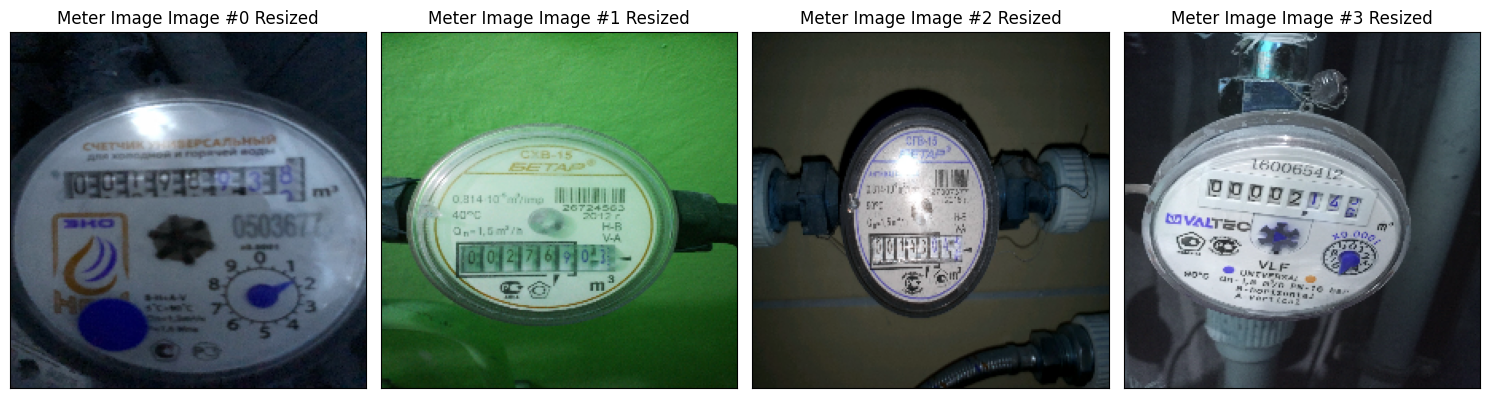

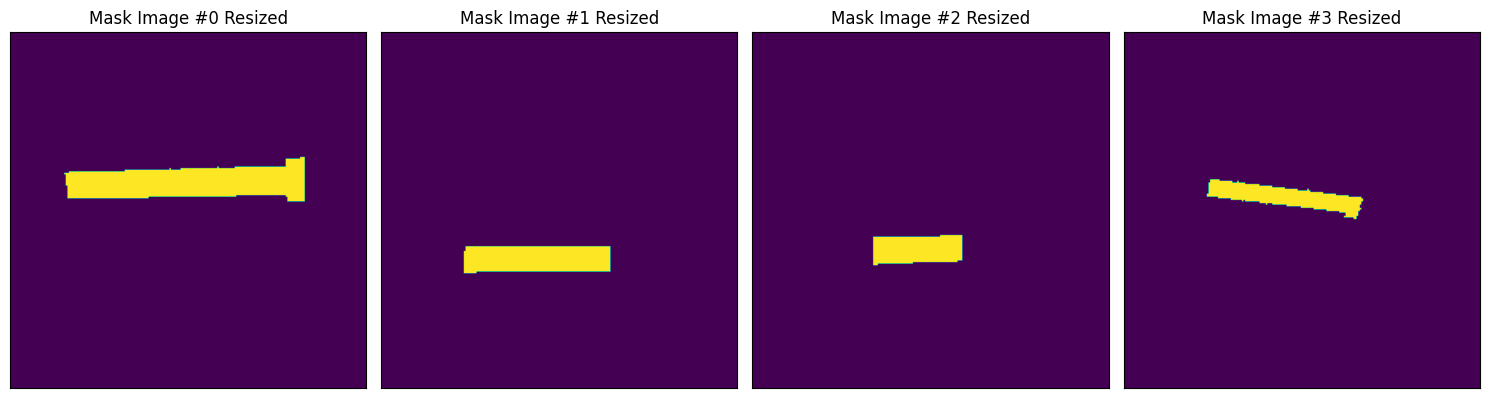

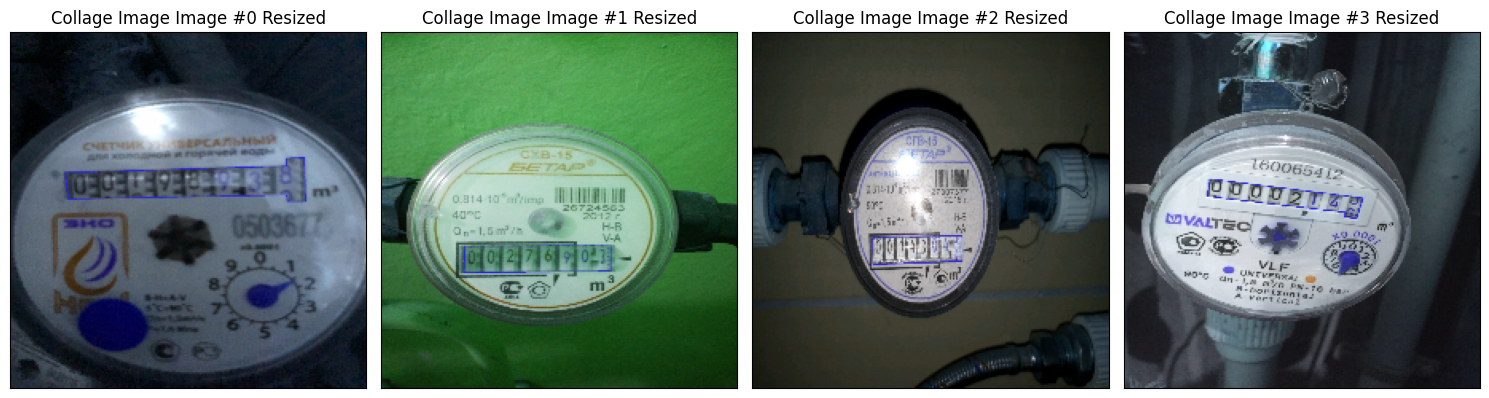

In [58]:
#Print first 4 resized meter, resized mask, and collage images.
plot_seg_imgs(X,'Meter Image')
plot_seg_imgs(y, 'Mask')
plot_seg_imgs('collage', 'Collage Image')

In [59]:
#Split data into train and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Segmentation Mask

In [60]:
!pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.0 MB/s eta 0:00:00


In [61]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [62]:
%%capture

#Download presaved weights
!wget https://github.com/K-Merrick/Water-Meters/blob/main/weights-file.hdf5

In [63]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

#Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile(
    opt,
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

try:

    fname = '../input/weights/weights-file.hdf5'
    print('Weights file loaded.')
except:
    pass

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='new_weights_output.hdf5',
    save_weights_only=False,
    monitor='val_iou_score',
    mode='max',
    save_best_only=True,
    verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)

if os.path.isfile(fname) == True:
    model.load_weights(fname)

# fit model
model.fit(
   x=X_train,
   y=y_train,
   batch_size=16,
   epochs=100,
   validation_data=(X_test, y_test),
   callbacks=[model_checkpoint_callback, early_stopping]
)

model.save('/content/drive/MyDrive/final_segmentation_model')



85521592/85521592 [==============================] - 0s 0us/step
Weights file loaded.
Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 1.6033 - iou_score: 0.0348
Epoch 1: val_iou_score improved from -inf to 0.03478, saving model to new_weights_output.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 75s 312ms/step - loss: 1.6033 - iou_score: 0.0348 - val_loss: 1.6295 - val_iou_score: 0.0348
Epoch 2/100
63/63 [==============================] - ETA: 0s - loss: 1.3325 - iou_score: 0.0569
Epoch 2: val_iou_score improved from 0.03478 to 0.04244, saving model to new_weights_output.hdf5
63/63 [==============================] - 15s 242ms/step - loss: 1.3325 - iou_score: 0.0569 - val_loss: 1.3535 - val_iou_score: 0.0424
Epoch 3/100
63/63 [==============================] - ETA: 0s - loss: 1.2073 - iou_score: 0.0782
Epoch 3: val_iou_score improved from 0.04244 to 0.06860, saving model to new_weights_output.hdf5
63/63 [==============================] - 19s 307ms/step - loss: 1.2073 - iou_score: 0.0782 - val_loss: 1.2215 - val_iou_score: 0.0686
Epoch 4/100
63/63 [==============================] - ETA: 0s - loss: 1.1253 - iou_score: 0.0983
Epoch 4: val_iou_score improved from 0.06860 to 0.08293, saving model to new_weights_output.hdf5
63/63 [============

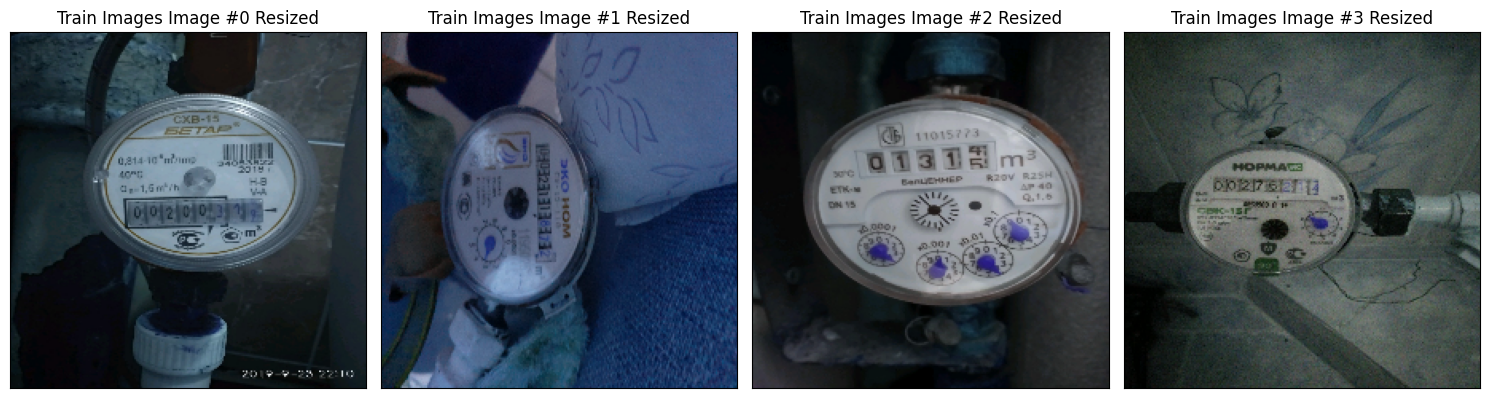

32/32 [==============================] - 8s 118ms/step


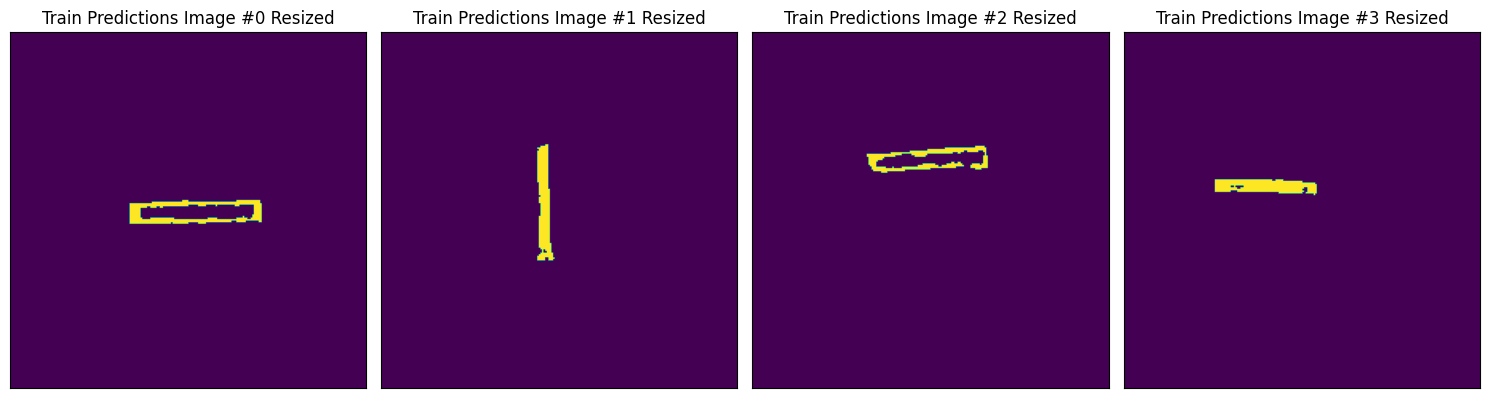

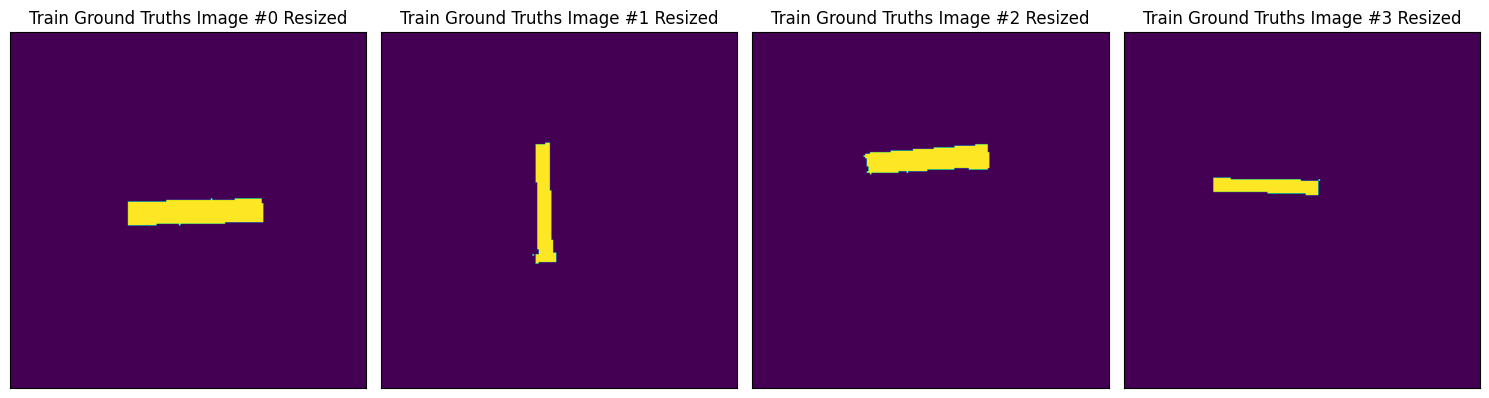

In [64]:
# Examine predictions for training images.
plot_seg_imgs(X_train, 'Train Images')
plot_seg_imgs(model.predict(X_train), 'Train Predictions')
plot_seg_imgs(y_train, 'Train Ground Truths')

Crop Images

In [65]:
#Create function to crop images.
def crop(img, bg, mask) -> np.array:
    '''
    Function takes image, background, and mask, and crops the image.
    The cropped image should correspond only with the positive portion of the mask.
    '''
    fg = cv2.bitwise_or(img, img, mask=mask)
    fg_back_inv = cv2.bitwise_or(bg, bg, mask=cv2.bitwise_not(mask))
    New_image = cv2.bitwise_or(fg, fg_back_inv)
    return New_image

In [66]:
#%%skip True

#Crop training images using supplied masks.
if os.path.exists('./cropped') == False:
    os.mkdir('cropped')
else:
    pass

ocr_path = './cropped'

for n, image, mask in tqdm(zip(range(len(os.listdir(images_folder))), os.listdir(images_folder), os.listdir(masks_folder))):
    dir_img = os.path.join(images_folder, image)
    dir_mask = os.path.join(masks_folder, mask)

    #Read images and masks.
    img = cv2.imread(dir_img).astype('uint8')
    mask = cv2.imread(dir_mask).astype('uint8')

    #Get dimensions of image.
    h, w, _ = img.shape

    #Ensure mask is binary, and create black background in shape of image.
    mask = cv2.resize(cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY), (w, h)) # Resize image
    bg = np.zeros_like(img, 'uint8') # Black background

    #Crop image based on mask and make it RBG.
    New_image = crop(img,bg,mask)
    New_image = cv2.cvtColor(New_image, cv2.COLOR_BGR2RGB)

    #Extract portion of image where meter reading is.
    #Use min and max x and y coordinates to obtain final image.
    where = np.array(np.where(New_image))
    x1, y1, z1 = np.amin(where, axis=1)
    x2, y2, z2 = np.amax(where, axis=1)
    sub_image = New_image.astype('uint8')[x1:x2, y1:y2]

    #Write image to file
    cv2.imwrite(os.path.join(ocr_path , image), sub_image)

1244it [01:12, 17.18it/s]


Deskew Images

In [67]:
%%capture

from skimage import io
from skimage.transform import rotate
from skimage.color import rgb2gray
try:
    from deskew import determine_skew
except:
    !pip install deskew
    from deskew import determine_skew
from typing import Tuple, Union
import math

In [68]:
def rotate(image: np.ndarray, angle: float, background: Union[int, Tuple[int, int, int]]) -> np.ndarray:
    '''
    This function attempts to rotate meter reading images to make them horizontal.
    Its arguments are as follows:

    image - The image to be deskewed (in numpy array format).
    angle - The current angle of the image, found with the determine_skew function of the deskew library.
    background - The pixel values of the boarder, either int (default 0) or a tuple.

    The function returns a numpy array.
    '''
    old_width, old_height = image.shape[:2]
    angle_radian = math.radians(angle)
    width = abs(np.sin(angle_radian) * old_height) + abs(np.cos(angle_radian) * old_width)
    height = abs(np.sin(angle_radian) * old_width) + abs(np.cos(angle_radian) * old_height)

    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    rot_mat[1, 2] += (width - old_width) / 2
    rot_mat[0, 2] += (height - old_height) / 2

    return cv2.warpAffine(image, rot_mat, (int(round(height)), int(round(width))), borderValue=background)

In [69]:
def resize_aspect_fit(path, final_size: int, write_to, save=True):
    '''
    Function resizes the image to specified size.

    path - The path to the directory with images.
    final_size - The size you want the final images to be. Should be in int (will be used for w and h).
    write_to - The file you wish to write the images to.
    save - Whether to save the files (True) or return them.
    '''
    for item in tqdm(os.listdir(path)):
        im = Image.open(path+item)
        f, e = os.path.splitext(path+item)
        size = im.size
        ratio = float(final_size) / max(size)
        new_image_size = tuple([int(x*ratio) for x in size])
        im = im.resize(new_image_size, Image.ANTIALIAS)
        new_im = Image.new("RGB", (final_size, final_size))
        new_im.paste(im, ((final_size-new_image_size[0])//2, (final_size-new_image_size[1])//2))
        if save==True:
            cv2.imwrite(os.path.join(resize_for_rcnn, item), np.array(new_im))
        else:
            return np.array(new_im)

In [71]:
#%%skip True

#Create new directory for images if they haven't been saved yet.
if os.path.exists('./cropped_components') == False:
    os.mkdir('cropped_components')
else:
    pass

components_path = './cropped_components'

#Create new image depicting rotated meter reading.
for n, image in tqdm(zip(range(1244), os.listdir('./cropped'))):

    #Rotate all images and write to file.
    dir_img = os.path.join('./cropped', image)
    photo = cv2.imread(os.path.join(dir_img))
    grayscale = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)
    angle = determine_skew(grayscale)
    try:
        rotated = rotate(photo, angle, (0, 0, 0))
    except:
        rotated = photo
    cv2.imwrite(os.path.join(components_path , image), rotated)

1244it [00:42, 29.00it/s]


Resize images

In [72]:
#%%skip True

#Reshape all images to 224x224x3 size, while retaining aspect.
#IMPORTANT FOR PREPROCESSING IMAGES

from PIL import Image
import os, sys

if os.path.exists('./resized_for_Ada') == False:
    os.mkdir('resized_for_Ada')
else:
    pass

#Specify argument values for resize function.
resize_for_rcnn = './resized_for_Ada'
path = './cropped_components/'
final_size = 224

resize_aspect_fit(path, final_size, resize_for_rcnn)

  0%|          | 0/1244 [00:00<?, ?it/s]<ipython-input-69-ca62c9f4f55f>:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_image_size, Image.ANTIALIAS)
100%|██████████| 1244/1244 [00:04<00:00, 296.07it/s]


# Segmenting indivivdual digits

Annotations of bounding boxes around digits and correct digit values

In [73]:
import cv2
import json
import os

def annotate_images(image_folder, annotation_file, output_folder):
    # Load annotation data from the JSON file
    with open(annotation_file, 'r') as f:
        annotation_data = json.load(f)

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Loop through the images in the folder
    for image_info in annotation_data["images"]:
        image_id = image_info["id"]
        image_filename = image_info["file_name"]

        # Load the image
        image_path = os.path.join(image_folder, image_filename)
        image = cv2.imread(image_path)

        if image is not None:
            # Get the annotations for the current image
            image_annotations = [annotation for annotation in annotation_data["annotations"] if annotation["image_id"] == image_id]

            for annotation in image_annotations:
                x, y, width, height = annotation['bbox']
                label_id = annotation['category_id']

                # Find the label name corresponding to the label_id
                label_name = next((category["name"] for category in annotation_data["categories"] if category["id"] == label_id), "Unknown")

                # Draw the bounding box on the image
                color = (0, 255, 0)
                thickness = 2
                cv2.rectangle(image, (int(x), int(y)), (int(x + width), int(y + height)), color, thickness)

                # Display the label near the bounding box
                text = f"{label_name}"
                cv2.putText(image, text, (int(x), int(y) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, thickness)

            # Save the annotated image with bounding boxes
            annotated_image_filename = f'annotated_{image_filename}'
            annotated_image_path = os.path.join(output_folder, annotated_image_filename)
            cv2.imwrite(annotated_image_path, image)
        else:
            print(f"Failed to load image: {image_path}")

# Define paths to your train, test, and validation sets
train_image_folder = '/content/drive/MyDrive/HonoursProject/roboflow/train'
train_annotation_file = '/content/drive/MyDrive/HonoursProject/roboflow/train/_annotations.coco.json'
train_output_folder = '/content/drive/MyDrive/train_annotated'

test_image_folder = '/content/drive/MyDrive/HonoursProject/roboflow/test'
test_annotation_file = '/content/drive/MyDrive/HonoursProject/roboflow/test/_annotations.coco.json'
test_output_folder = '/content/drive/MyDrive/test_annotated'

valid_image_folder = '/content/drive/MyDrive/HonoursProject/roboflow/valid'
valid_annotation_file = '/content/drive/MyDrive/HonoursProject/roboflow/valid/_annotations.coco.json'
valid_output_folder = '/content/drive/MyDrive/valid_annotated'

# Annotate images for the train set
annotate_images(train_image_folder, train_annotation_file, train_output_folder)
print("Train set annotation completed.")

# Annotate images for the test set
annotate_images(test_image_folder, test_annotation_file, test_output_folder)
print("Test set annotation completed.")

# Annotate images for the validation set
annotate_images(valid_image_folder, valid_annotation_file, valid_output_folder)
print("Validation set annotation completed.")


Train set annotation completed.
Failed to load image: /content/drive/MyDrive/HonoursProject/roboflow/test/id_14_value_14_954_jpg.rf.dce85317348493da6b82a0f47efd9a93.jpg
Test set annotation completed.
Validation set annotation completed.


Creating masks for individual digits in reading

In [ ]:
import cv2
import json
import os
import numpy as np

# Define a function to create masks from annotations
def create_masks(image_folder, annotations_file, output_folder):
    # Load annotation data from the JSON file
    with open(annotations_file, 'r') as f:
        annotation_data = json.load(f)

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Loop through the images in the folder
    for image_info in annotation_data["images"]:
        image_id = image_info["id"]
        image_filename = image_info["file_name"]

        # Load the image
        image_path = os.path.join(image_folder, image_filename)
        print("Loading image:", image_path)
        image = cv2.imread(image_path)

        if image is None:
            print("Failed to load image:", image_path)
            continue

        # Get the annotations for the current image
        image_annotations = [annotation for annotation in annotation_data["annotations"] if annotation["image_id"] == image_id]

        # Create a binary mask for the meter reading
        meter_mask = np.zeros(image.shape[:2], dtype=np.uint8)

        for annotation in image_annotations:
            x, y, width, height = annotation['bbox']

            # Draw  rectangles on the mask for the digits
            cv2.rectangle(meter_mask, (int(x), int(y)), (int(x + width), int(y + height)), 255, thickness=cv2.FILLED)

        # Save the mask to the output folder
        mask_filename = f'mask_{image_filename}'
        mask_path = os.path.join(output_folder, mask_filename)
        cv2.imwrite(mask_path, meter_mask)

    print("Masks for digit positions created and saved to", output_folder)

# Define paths to your train, test, and validation datasets
train_image_folder = '/content/drive/MyDrive/HonoursProject/roboflow/train'
train_annotation_file = '/content/drive/MyDrive/HonoursProject/roboflow/train/_annotations.coco.json'
train_output_folder = '/content/drive/MyDrive/train_masks'

test_image_folder = '/content/drive/MyDrive/HonoursProject/roboflow/test'
test_annotation_file = '/content/drive/MyDrive/HonoursProject/roboflow/test/_annotations.coco.json'
test_output_folder = '/content/drive/MyDrive/test_masks'

valid_image_folder = '/content/drive/MyDrive/HonoursProject/roboflow/valid'
valid_annotation_file = '/content/drive/MyDrive/HonoursProject/roboflow/valid/_annotations.coco.json'
valid_output_folder = '/content/drive/MyDrive/valid_masks'

# Create masks for the train set
create_masks(train_image_folder, train_annotations_file, train_output_folder)

# Create masks for the test set
create_masks(test_image_folder, test_annotations_file, test_output_folder)

# Create masks for the validation set
create_masks(valid_image_folder, valid_annotations_file, valid_output_folder)


Segment individual digits in training set

In [ ]:
import cv2
import json
import os
import numpy as np

# Define the paths
image_folder = '/content/drive/MyDrive/HonoursProject/roboflow/train'
annotations_file = '/content/drive/MyDrive/HonoursProject/roboflow/train/_annotations.coco.json'
output_folder = '/content/drive/MyDrive/segmented_parts'

# Load annotation data from the JSON file
with open(annotations_file, 'r') as f:
    annotation_data = json.load(f)

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Loop through the images in the folder
for image_info in annotation_data["images"]:
    image_id = image_info["id"]
    image_filename = image_info["file_name"]

    # Load the image
    image_path = os.path.join(image_folder, image_filename)
    image = cv2.imread(image_path)

    # Get the annotations for the current image
    image_annotations = [annotation for annotation in annotation_data["annotations"] if annotation["image_id"] == image_id]

    # Create a binary mask for the meter reading
    meter_mask = np.zeros_like(image)

    for annotation in image_annotations:
        x, y, width, height = annotation['bbox']

        # Draw rectangles on the mask for the digits
        cv2.rectangle(meter_mask, (int(x), int(y)), (int(x + width), int(y + height)), (255, 255, 255), thickness=cv2.FILLED)

    # Extract the segmented parts from the original image using the mask
    segmented_parts = cv2.bitwise_and(image, meter_mask)

    # Save the image with segmented parts to the output folder
    segmented_parts_filename = f'segmented_parts_{image_filename}'
    segmented_parts_path = os.path.join(output_folder, segmented_parts_filename)
    cv2.imwrite(segmented_parts_path, segmented_parts)

print("Segmented parts extracted and saved to", output_folder)


Segmented parts extracted and saved to /content/drive/MyDrive/segmented_parts


Segment individual digits in validation set

In [74]:
import cv2
import json
import os
import numpy as np


image_folder = '/content/drive/MyDrive/HonoursProject/roboflow/valid'
annotations_file = '/content/drive/MyDrive/HonoursProject/roboflow/valid/_annotations.coco.json'
output_folder = '/content/drive/MyDrive/segmented_parts_valid'

# Load annotation data from the JSON file
with open(annotations_file, 'r') as f:
    annotation_data = json.load(f)

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Loop through the images in the folder
for image_info in annotation_data["images"]:
    image_id = image_info["id"]
    image_filename = image_info["file_name"]

    # Load the image
    image_path = os.path.join(image_folder, image_filename)
    image = cv2.imread(image_path)

    # Get the annotations for the current image
    image_annotations = [annotation for annotation in annotation_data["annotations"] if annotation["image_id"] == image_id]

    # Create a binary mask for the meter reading
    meter_mask = np.zeros_like(image)

    for annotation in image_annotations:
        x, y, width, height = annotation['bbox']

        # Draw  rectangles on the mask for the digits
        cv2.rectangle(meter_mask, (int(x), int(y)), (int(x + width), int(y + height)), (255, 255, 255), thickness=cv2.FILLED)

    # Extract the segmented parts from the original image using the mask
    segmented_parts = cv2.bitwise_and(image, meter_mask)

    # Save the image with segmented parts to the output folder
    segmented_parts_filename = f'segmented_parts_{image_filename}'
    segmented_parts_path = os.path.join(output_folder, segmented_parts_filename)
    cv2.imwrite(segmented_parts_path, segmented_parts)

print("Segmented parts extracted and saved to", output_folder)


Segmented parts extracted and saved to /content/drive/MyDrive/segmented_parts_valid


# Calculating integral images and haar features

In [81]:

import cv2
import json
import os
import numpy as np
import pandas as pd
image_folder = '/content/drive/MyDrive/HonoursProject/roboflow/train'
annotations_file = '/content/drive/MyDrive/HonoursProject/roboflow/train/_annotations.coco.json'


Segmenting each digit image

In [82]:

# Load annotation data from the JSON file
with open(annotations_file, 'r') as f:
    annotation_data = json.load(f)

# Define a dictionary to store the segments for each image
image_segments = {}

# Loop through the images in the folder
for image_info in annotation_data["images"]:
    image_id = image_info["id"]
    image_filename = image_info["file_name"]
    image_path = os.path.join(image_folder, image_filename)
    image = cv2.imread(image_path)

    # Get the annotations for the current image
    image_annotations = [annotation for annotation in annotation_data["annotations"] if annotation["image_id"] == image_id]


    # Determine the size of the combined image
    max_width = int(max([annotation['bbox'][0] + annotation['bbox'][2] for annotation in image_annotations]))
    max_height = int(max([annotation['bbox'][1] + annotation['bbox'][3] for annotation in image_annotations]))


    # Create the combined image
    combined_image = np.zeros((max_height, max_width, 3), dtype=np.uint8)

    # Initialize the list to store segments for the current image
    segments = []

    for annotation in image_annotations:
        x, y, width, height = annotation['bbox']


        # Extract the segment from the original image
        segment = image[int(y):int(y+height), int(x):int(x+width)]


        # Calculate the integral image for the segment
        integral_image = cv2.integral(segment)

        # Store the integral image in the list of segments
        segments.append({"segment_image": segment, "integral_image": integral_image})


        # Place the segment within the combined image
        combined_image[int(y):int(y+height), int(x):int(x+width)] = segment


    # Store the segments for the current image
    image_segments[image_filename] = segments




Calculate integral image for each digit segment

In [83]:
# Load annotation data from the JSON file
with open(annotations_file, 'r') as f:
    annotation_data = json.load(f)


image_segments = {}


for image_info in annotation_data["images"]:
    image_id = image_info["id"]
    image_filename = image_info["file_name"]
    image_path = os.path.join(image_folder, image_filename)
    image = cv2.imread(image_path)

    # Get the annotations for the current image
    image_annotations = [annotation for annotation in annotation_data["annotations"] if annotation["image_id"] == image_id]

    # Determine the size of the combined image
    max_width = int(max([annotation['bbox'][0] + annotation['bbox'][2] for annotation in image_annotations]))
    max_height = int(max([annotation['bbox'][1] + annotation['bbox'][3] for annotation in image_annotations]))

    # Create the combined image
    combined_image = np.zeros((max_height, max_width, 3), dtype=np.uint8)

    # Initialize the list to store segments for the current image
    segments = []

    for annotation in image_annotations:
        x, y, width, height = annotation['bbox']

        # Extract the segment from the original image
        segment = image[int(y):int(y+height), int(x):int(x+width)]

        # Calculate the integral image for the segment
        integral_image = cv2.integral(segment)

        # Store the integral image in the list of segments
        segments.append({"segment_image": segment, "integral_image": integral_image})

        # Place the segment within the combined image
        combined_image[int(y):int(y+height), int(x):int(x+width)] = segment

    # Store the segments for the current image
    image_segments[image_filename] = segments

# function to extract Haar-like features
def calculate_haar_feature(integral_image, squared_integral_image, feature_type, x, y, width, height):
    if feature_type == 'haar1':
        # Calculate the Haar-like feature (for the entire region)
        feature_value = squared_integral_image[y + height, x + width] - squared_integral_image[y, x + width] - squared_integral_image[y + height, x] + squared_integral_image[y, x]
    elif feature_type == 'haar2':
        # Calculate the Haar-like feature (divided into two horizontal rectangles)
        half_height = height // 2
        feature_value = squared_integral_image[y + half_height, x + width] - squared_integral_image[y, x + width] - squared_integral_image[y + height, x] + squared_integral_image[y + half_height, x] - squared_integral_image[y + height, x + width] + squared_integral_image[y, x + width] + squared_integral_image[y + height, x] - squared_integral_image[y, x]
    else:
        feature_value = 0
    return feature_value



# Loop through the segments and extract Haar-like features
for image_name, segments in image_segments.items():
    print(f'Haar-like Features for {image_name}:')
    image_id = image_name.split('_')[1]
    image_annotations = [annotation for annotation in annotation_data["annotations"] if annotation["image_id"] == int(image_id)]

    for i, segment_data in enumerate(segments):
        segment_image = segment_data["segment_image"]

        # Calculate the integral images using cv2.integral2
        integral_image, squared_integral_image = cv2.integral2(segment_image)

        feature_type = 'haar1'

        # Get the dimensions of the segment image
        segment_height, segment_width, _ = segment_image.shape

        if i < len(image_annotations):
            annotation = image_annotations[i]

            # Define the position and size based on the segment's bounding box
            x, y, width, height = [int(val) for val in annotation['bbox']]

            # Make sure the region is within bounds
            x = max(0, min(x, segment_width - 1))
            y = max(0, min(y, segment_height - 1))
            width = min(width, segment_width - x)
            height = min(height, segment_height - y)

            # Extract Haar-like feature using the squared integral image
            feature_value = calculate_haar_feature(integral_image, squared_integral_image, feature_type, x, y, width, height)

            print(f"Segment {i + 1} Haar-like feature value ({feature_type}):", feature_value)
            print(f"Segment {i + 1} Integral image ({feature_type}):", squared_integral_image)



Streaming output truncated to the last 5000 lines.
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00]]

 [[0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [1.0000000e+02 4.8400000e+02 2.1160000e+03]
  [2.9600000e+02 1.1600000e+03 4.6160000e+03]
  ...
  [8.1550000e+03 1.3870000e+04 3.7009000e+04]
  [8.3800000e+03 1.4270000e+04 3.8690000e+04]
  [9.6050000e+03 1.6034000e+04 4.2534000e+04]]

 [[0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [7.3250000e+03 1.0888000e+04 2.0341000e+04]
  [1.6737000e+04 2.3885000e+04 4.3290000e+04]
  ...
  [1.4238000e+05 1.8208600e+05 2.9949600e+05]
  [1.5492600e+05 1.9617500e+05 3.2249300e+05]
  [1.7865100e+05 2.2290300e+05 3.6130600e+05]]

 ...

 [[0.0000000e+00 0.0000000e+00 0.0000000e+00]
  [4.8658000e+05 6.4301200e+05 1.0204720e+06]
  [9.8962100e+05 1.3086990e+06 2.0573950e+06]

In [84]:

with open(annotations_file, 'r') as f:
    annotation_data = json.load(f)

# Initialize lists to store features and labels
features_list = []
labels_list = []

# Loop through the images in the folder
for image_info in annotation_data["images"]:
    image_id = image_info["id"]
    image_filename = image_info["file_name"]
    image_path = os.path.join(image_folder, image_filename)
    image = cv2.imread(image_path)

    # Get the annotations for the current image
    image_annotations = [annotation for annotation in annotation_data["annotations"] if annotation["image_id"] == image_id]

    for i, segment_data in enumerate(image_segments[image_filename]):
        segment_image = segment_data["segment_image"]

        # Calculate the integral images using cv2.integral2
        integral_image, squared_integral_image = cv2.integral2(segment_image)

        # Define the feature type (you can change this)
        feature_type = 'haar1'

        # Get the dimensions of the segment image
        segment_height, segment_width, _ = segment_image.shape

        if i < len(image_annotations):
            annotation = image_annotations[i]

            # Define the position and size based on the segment's bounding box
            x, y, width, height = [int(val) for val in annotation['bbox']]

            # Make sure the region is within bounds
            x = max(0, min(x, segment_width - 1))
            y = max(0, min(y, segment_height - 1))
            width = min(width, segment_width - x)
            height = min(height, segment_height - y)

            # Extract Haar-like feature using the squared integral image
            feature_value = calculate_haar_feature(integral_image, squared_integral_image, feature_type, x, y, width, height)


            # Get the label (the digit value) associated with this segment
            label = annotation['category_id']

            # Append the feature and label to the respective lists
            features_list.append(feature_value)
            labels_list.append(label)

# Create a DataFrame to store the features and labels
data = pd.DataFrame({'Feature': features_list, 'Label': labels_list})

# Save the labeled dataset to a CSV file
data.to_csv('labeled_dataset_train.csv', index=False)

In [78]:
print("Number of features collected:", len(features_list))
print("Number of labels collected:", len(labels_list))

Number of features collected: 3401
Number of labels collected: 3401




# Classification and evaluation



In [85]:
import cv2
import json
import os
import numpy as np
import pandas as pd

!pip install pandas scikit-learn
image_folder = '/content/drive/MyDrive/HonoursProject/roboflow/valid'
annotations_file = '/content/drive/MyDrive/HonoursProject/roboflow/valid/_annotations.coco.json'

In [86]:

with open(annotations_file, 'r') as f:
    annotation_data = json.load(f)

# Define a dictionary to store the segments for each image
image_segments = {}

# Loop through the images in the folder
for image_info in annotation_data["images"]:
    image_id = image_info["id"]
    image_filename = image_info["file_name"]
    image_path = os.path.join(image_folder, image_filename)
    image = cv2.imread(image_path)

    # Get the annotations for the current image
    image_annotations = [annotation for annotation in annotation_data["annotations"] if annotation["image_id"] == image_id]

    # Determine the size of the combined image
    max_width = int(max([annotation['bbox'][0] + annotation['bbox'][2] for annotation in image_annotations]))
    max_height = int(max([annotation['bbox'][1] + annotation['bbox'][3] for annotation in image_annotations]))

    # Create the combined image
    combined_image = np.zeros((max_height, max_width, 3), dtype=np.uint8)

    # Initialize the list to store segments for the current image
    segments = []

    for annotation in image_annotations:
        x, y, width, height = annotation['bbox']

        # Extract the segment from the original image
        segment = image[int(y):int(y+height), int(x):int(x+width)]

        # Calculate the integral image for the segment
        integral_image = cv2.integral(segment)

        # Store the integral image in the list of segments
        segments.append({"segment_image": segment, "integral_image": integral_image})

        # Place the segment within the combined image
        combined_image[int(y):int(y+height), int(x):int(x+width)] = segment

    # Store the segments for the current image
    image_segments[image_filename] = segments

# Define a function to extract Haar-like features
def calculate_haar_feature(integral_image, squared_integral_image, feature_type, x, y, width, height):
    if feature_type == 'haar1':
        # Calculate the Haar-like feature (for the entire region)
        feature_value = squared_integral_image[y + height, x + width] - squared_integral_image[y, x + width] - squared_integral_image[y + height, x] + squared_integral_image[y, x]
    elif feature_type == 'haar2':
        # Calculate the Haar-like feature (divided into two horizontal rectangles)
        half_height = height // 2
        feature_value = squared_integral_image[y + half_height, x + width] - squared_integral_image[y, x + width] - squared_integral_image[y + height, x] + squared_integral_image[y + half_height, x] - squared_integral_image[y + height, x + width] + squared_integral_image[y, x + width] + squared_integral_image[y + height, x] - squared_integral_image[y, x]
    else:
        feature_value = 0
    return feature_value



# Loop through the segments and extract Haar-like features
for image_name, segments in image_segments.items():
    print(f'Haar-like Features for {image_name}:')
    image_id = image_name.split('_')[1]
    image_annotations = [annotation for annotation in annotation_data["annotations"] if annotation["image_id"] == int(image_id)]

    for i, segment_data in enumerate(segments):
        segment_image = segment_data["segment_image"]

        # Calculate the integral images using cv2.integral2
        integral_image, squared_integral_image = cv2.integral2(segment_image)

        feature_type = 'haar1'

        # Get the dimensions of the segment image
        segment_height, segment_width, _ = segment_image.shape

        if i < len(image_annotations):
            annotation = image_annotations[i]

            # Define the position and size based on the segment's bounding box
            x, y, width, height = [int(val) for val in annotation['bbox']]

            # Make sure the region is within bounds
            x = max(0, min(x, segment_width - 1))
            y = max(0, min(y, segment_height - 1))
            width = min(width, segment_width - x)
            height = min(height, segment_height - y)

            # Extract Haar-like feature using the squared integral image
            feature_value = calculate_haar_feature(integral_image, squared_integral_image, feature_type, x, y, width, height)

            print(f"Segment {i + 1} Haar-like feature value ({feature_type}):", feature_value)

Haar-like Features for id_130_value_185_287.rf.13412622a7ef77a5ece87803cf5ffd1f.jpg:
Haar-like Features for id_123_value_337_294.rf.151700e13216ae57eb4af167f7c778a1.jpg:
Haar-like Features for id_1028_value_125_489_jpg.rf.1a749beb03036393c7e8b84b801e4295.jpg:
Haar-like Features for id_1077_value_308_371_jpg.rf.206b875fc79b9d081d79694ab823e290.jpg:
Haar-like Features for id_1206_value_33_069_jpg.rf.23e82140a28d1915e8684926b4e69730.jpg:
Haar-like Features for id_1081_value_42_119_jpg.rf.24ad2fac2a80200f3b135b15891fb07b.jpg:
Haar-like Features for id_1208_value_25_891_jpg.rf.2908c516a9a2606c592e815e0ecebb19.jpg:
Haar-like Features for id_1002_value_105_174.rf.285b36adf72c4d0a2acff2ee5fbdff89.jpg:
Haar-like Features for id_1072_value_643_452.rf.2a856053e5122b396a4c7b6a9f9a6e9f.jpg:
Haar-like Features for id_1122_value_62_663.rf.3a2718a9b531e076276b27d0f2afb32a.jpg:
Haar-like Features for id_1069_value_117_87.rf.3beef01aa4667a68e945eee0a5d4f4d8.jpg:
Haar-like Features for id_1028_value_125_

In [87]:

with open(annotations_file, 'r') as f:
    annotation_data = json.load(f)

# Initialize lists to store features and labels
features_list = []
labels_list = []

# Loop through the images in the folder
for image_info in annotation_data["images"]:
    image_id = image_info["id"]
    image_filename = image_info["file_name"]
    image_path = os.path.join(image_folder, image_filename)
    image = cv2.imread(image_path)

    # Get the annotations for the current image
    image_annotations = [annotation for annotation in annotation_data["annotations"] if annotation["image_id"] == image_id]

    for i, segment_data in enumerate(image_segments[image_filename]):
        segment_image = segment_data["segment_image"]

        # Calculate the integral images using cv2.integral2
        integral_image, squared_integral_image = cv2.integral2(segment_image)

        # Define the feature type (you can change this)
        feature_type = 'haar1'

        # Get the dimensions of the segment image
        segment_height, segment_width, _ = segment_image.shape

        if i < len(image_annotations):
            annotation = image_annotations[i]

            # Define the position and size based on the segment's bounding box
            x, y, width, height = [int(val) for val in annotation['bbox']]

            # Make sure the region is within bounds
            x = max(0, min(x, segment_width - 1))
            y = max(0, min(y, segment_height - 1))
            width = min(width, segment_width - x)
            height = min(height, segment_height - y)

            # Extract Haar-like feature using the squared integral image
            feature_value = calculate_haar_feature(integral_image, squared_integral_image, feature_type, x, y, width, height)


            # Get the label (the digit value) associated with this segment
            label = annotation['category_id']

            # Append the feature and label to the respective lists
            features_list.append(feature_value)
            labels_list.append(label)

# Create a DataFrame to store the features and labels
data = pd.DataFrame({'Feature': features_list, 'Label': labels_list})

# Save the labeled dataset to a CSV file
data.to_csv('labeled_dataset_valid.csv', index=False)

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report


# Load the data from the CSV files
data_train = pd.read_csv('/content/labeled_dataset_train.csv')
data_test = pd.read_csv('/content/labeled_dataset_valid.csv')

# Extract the features (X) and labels (y) and convert them to numeric values
X_train = data_train['Feature'].apply(lambda x: [float(e) for e in x.strip('[]').split()]).values.tolist()
y_train = data_train['Label'].values
X_test = data_test['Feature'].apply(lambda x: [float(e) for e in x.strip('[]').split()]).values.tolist()
y_test = data_test['Label'].values

# Split the labeled dataset into training and evaluation sets
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train an AdaBoost Classifier on the training dataset
ada_boost_classifier = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_boost_classifier.fit(X_train, y_train)

# Make predictions on the evaluation dataset
y_pred = ada_boost_classifier.predict(X_eval)

# Evaluate the model's performance on the evaluation set
accuracy = accuracy_score(y_eval, y_pred)
report = classification_report(y_eval, y_pred, zero_division=1)

# Print or display evaluation information
print("Evaluation Results:")
print(f"Accuracy: {accuracy}")
print(report)

# Make predictions on the valid dataset
y_test_pred = ada_boost_classifier.predict(X_test)





Evaluation Results:
Accuracy: 0.3245227606461087
              precision    recall  f1-score   support

           1       0.35      0.91      0.50       237
           2       0.29      0.04      0.06        57
           3       0.00      0.00      0.00        40
           4       0.00      0.00      0.00        55
           5       0.33      0.02      0.04        44
           6       0.00      0.00      0.00        50
           7       0.17      0.04      0.06        56
           8       0.09      0.02      0.04        46
           9       0.00      0.00      0.00        46
          10       0.00      0.00      0.00        50

    accuracy                           0.32       681
   macro avg       0.12      0.10      0.07       681
weighted avg       0.19      0.32      0.19       681



In [89]:
from sklearn.metrics import precision_score, recall_score, f1_score


# Evaluate the model's performance on the evaluation set
accuracy = accuracy_score(y_eval, y_pred)
precision = precision_score(y_eval, y_pred, average='weighted')  # Calculate weighted precision
recall = recall_score(y_eval, y_pred, average='weighted')  # Calculate weighted recall
f1 = f1_score(y_eval, y_pred, average='weighted')  # Calculate weighted F1 score
report = classification_report(y_eval, y_pred, zero_division=1)

# Print or display evaluation information
print("Evaluation Results:")
print(f"Accuracy: {accuracy}")
print(f"Precision (Weighted): {precision}")
print(f"Recall (Weighted): {recall}")
print(f"F1 Score (Weighted): {f1}")


# Make predictions on the test dataset
y_test_pred = ada_boost_classifier.predict(X_test)


Evaluation Results:
Accuracy: 0.3245227606461087
Precision (Weighted): 0.18676459370291967
Recall (Weighted): 0.3245227606461087
F1 Score (Weighted): 0.1906247332395888


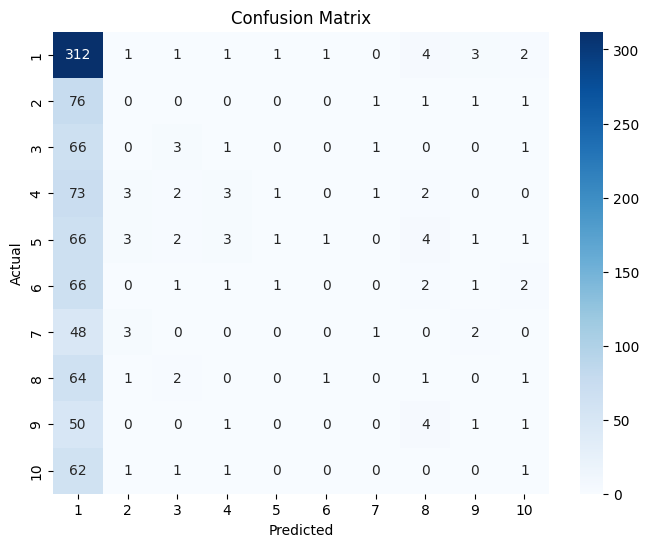

In [90]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix for the test dataset
confusion = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


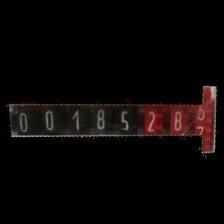

Predicted Labels for Segments: 1 2 1 1 1 1 1 1


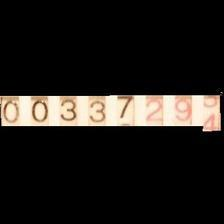

Predicted Labels for Segments: 1 1 1 1 6 1 3 6


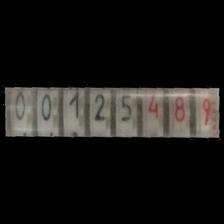

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


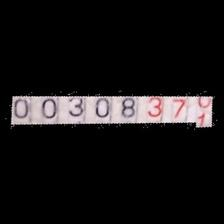

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


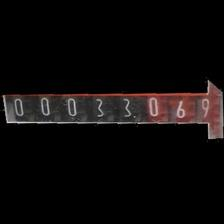

Predicted Labels for Segments: 1 1 1 1 1 1 1 4


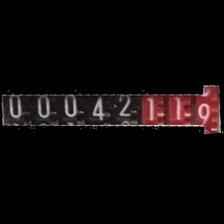

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


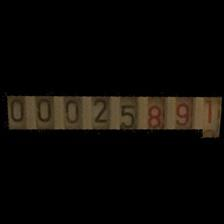

Predicted Labels for Segments: 1 1 1 1 1 4 1 1


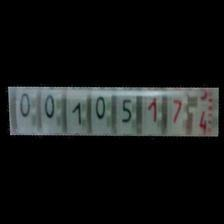

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


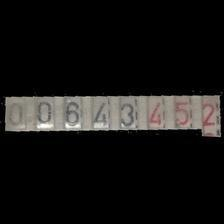

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


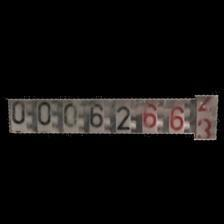

Predicted Labels for Segments: 1 1 1 1 1 2 1 1


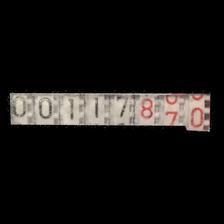

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


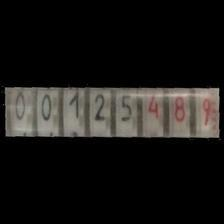

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


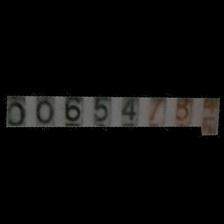

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


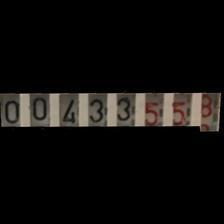

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


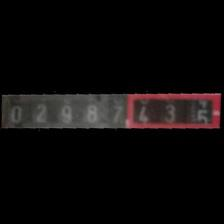

Predicted Labels for Segments: 1 1 1 1 1 1 1 5


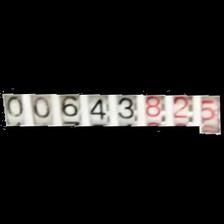

Predicted Labels for Segments: 1 1 1 1 1 10 1 1


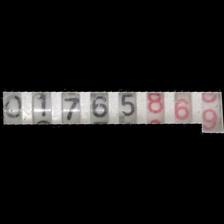

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


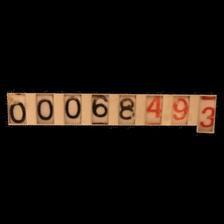

Predicted Labels for Segments: 1 1 1 1 1 5 1 1


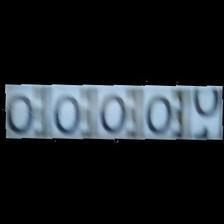

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


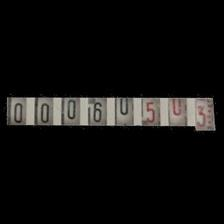

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


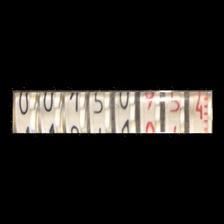

Predicted Labels for Segments: 4 8 1 10 1 1 1 1


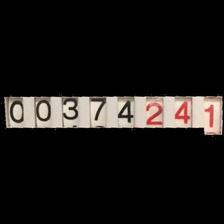

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


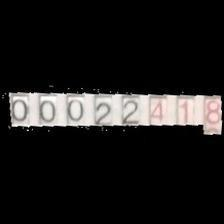

Predicted Labels for Segments: 1 1 8 10 1 1 1 1


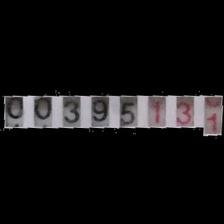

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


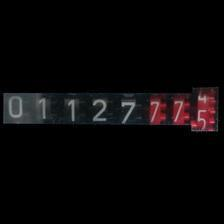

Predicted Labels for Segments: 1 1 1 2 1 1 1 1


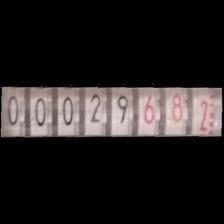

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


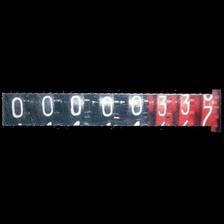

Predicted Labels for Segments: 1 1 4 4 10 1 1 1


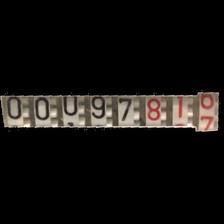

Predicted Labels for Segments: 10 1 1 8 1 1 1 1


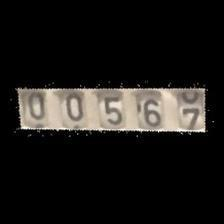

Predicted Labels for Segments: 1 3 8 1 1 8 1 1


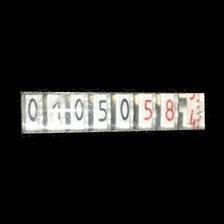

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


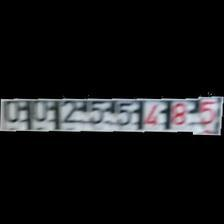

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


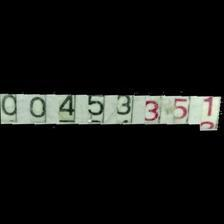

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


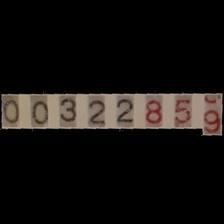

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


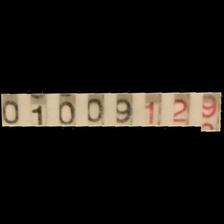

Predicted Labels for Segments: 1 1 1 1 1 1 1 8


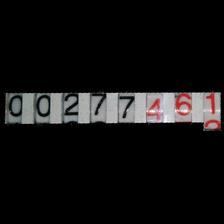

Predicted Labels for Segments: 1 1 1 1 7 1 9 9


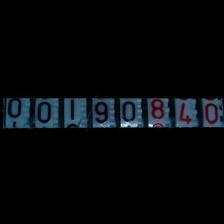

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


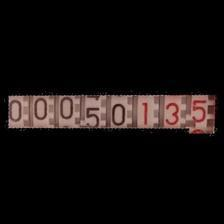

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


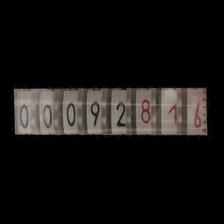

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


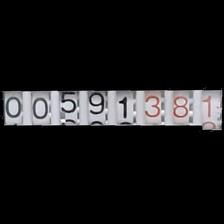

Predicted Labels for Segments: 1 1 1 1 1 1 1 10


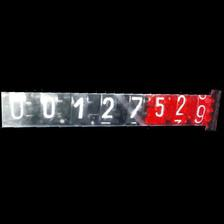

Predicted Labels for Segments: 3 1 1 1 1 1 1 1


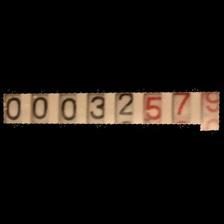

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


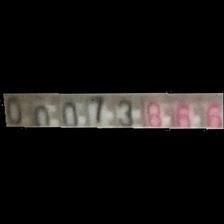

Predicted Labels for Segments: 1 1 1 1 8 1 1 1


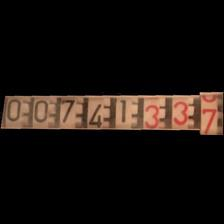

Predicted Labels for Segments: 2 1 8 1 1 1 1 1


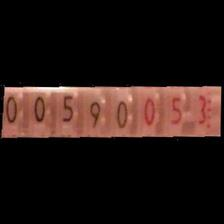

Predicted Labels for Segments: 1 1 1 1 1 9 9 1


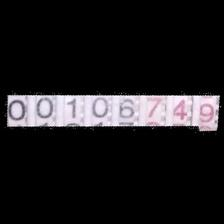

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


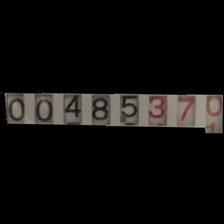

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


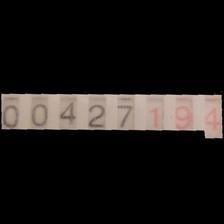

Predicted Labels for Segments: 1 1 4 1 1 1 1 1


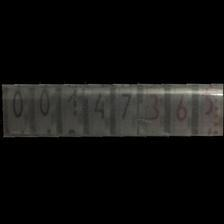

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


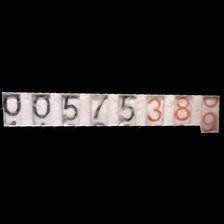

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


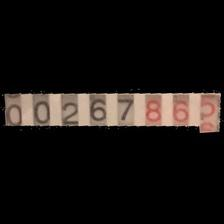

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


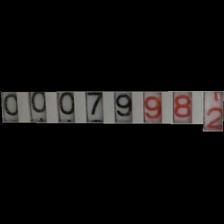

Predicted Labels for Segments: 1 1 1 1 4 4 8 1


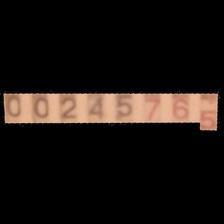

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


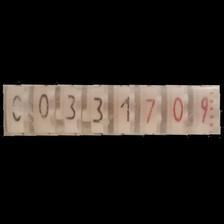

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


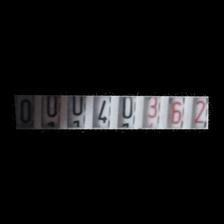

Predicted Labels for Segments: 1 1 10 1 1 1 1 1


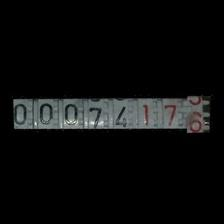

Predicted Labels for Segments: 1 2 1 1 1 1 1 1


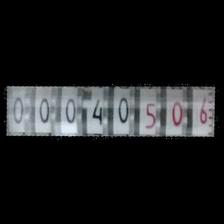

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


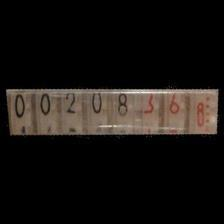

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


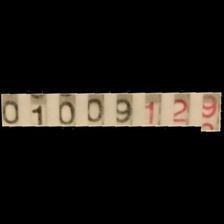

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


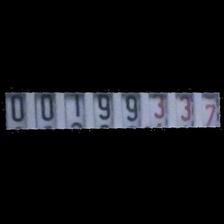

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


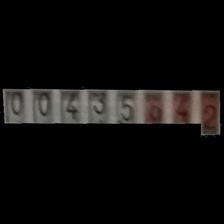

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


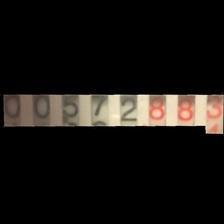

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


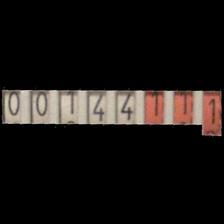

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


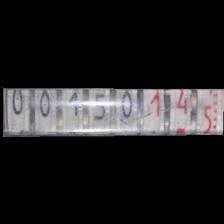

Predicted Labels for Segments: 1 1 1 1 1 1 1 4


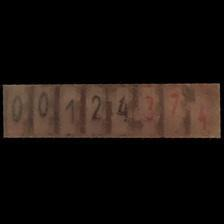

Predicted Labels for Segments: 1 1 1 1 3 1 1 1


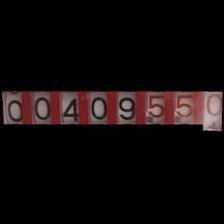

Predicted Labels for Segments: 1 1 1 1 1 1 1 8


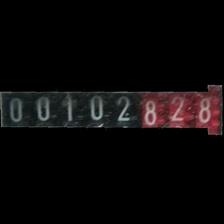

Predicted Labels for Segments: 1 8 1 1 1 1 1 3


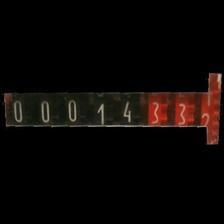

Predicted Labels for Segments: 1 3 1 1 1 1 1 7


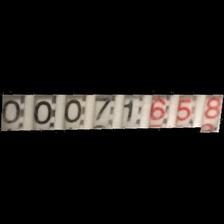

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


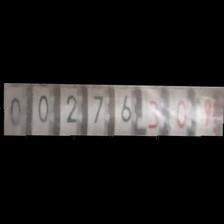

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


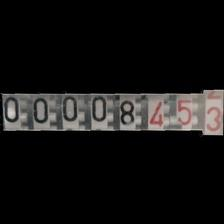

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


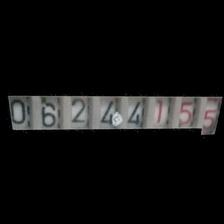

Predicted Labels for Segments: 1 1 1 1 2 1 1 1


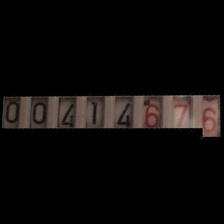

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


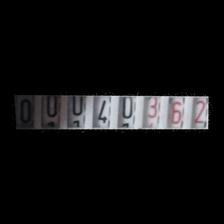

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


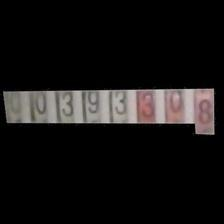

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


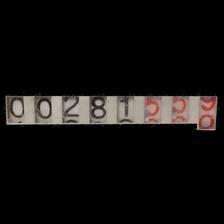

Predicted Labels for Segments: 1 1 1 1 1 1 1 8


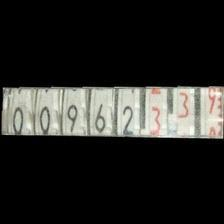

Predicted Labels for Segments: 8 1 1 1 1 1 1 1


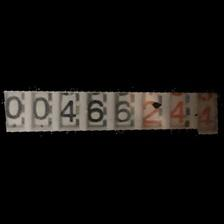

Predicted Labels for Segments: 4 1 8 1 1 1 1 1


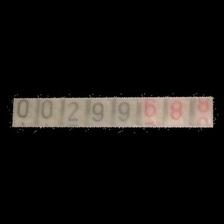

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


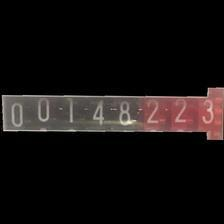

Predicted Labels for Segments: 1 1 1 6 3 9 1 9


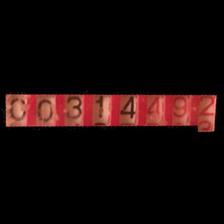

Predicted Labels for Segments: 1 3 1 1 2 1 1 1


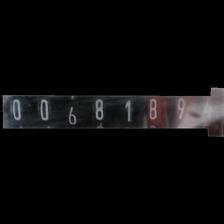

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


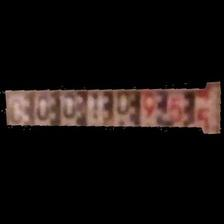

Predicted Labels for Segments: 3 9 1 1 1 1 1 1


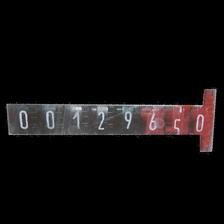

Predicted Labels for Segments: 1 1 5 1 1 1 1 1


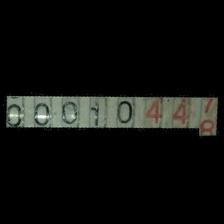

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


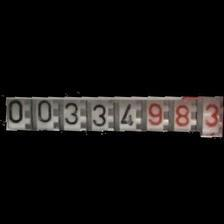

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


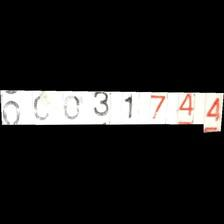

Predicted Labels for Segments: 1 10 1 1 1 1 1 1


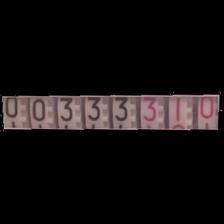

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


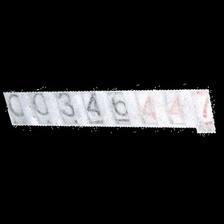

Predicted Labels for Segments: 8 1 1 1 1 1 1 1


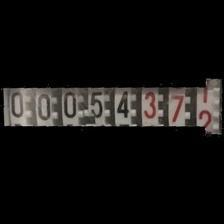

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


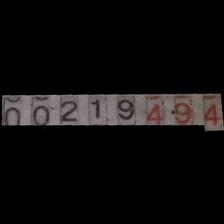

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


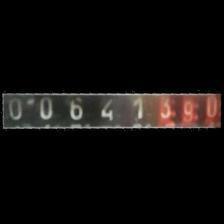

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


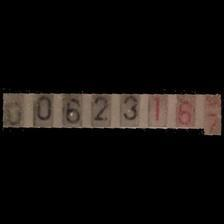

Predicted Labels for Segments: 1 1 1 1 1 1 1 5


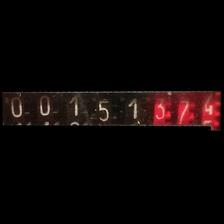

Predicted Labels for Segments: 3 3 1 1 1 1 1 1


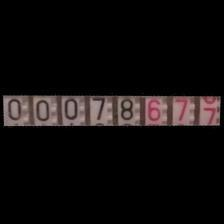

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


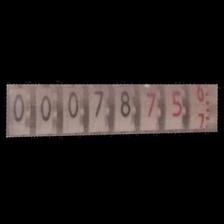

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


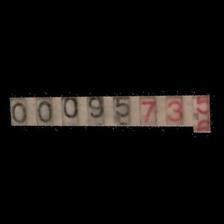

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


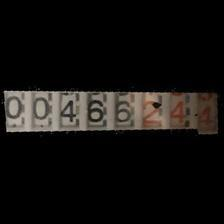

Predicted Labels for Segments: 4 1 1 1 1 1 1 1


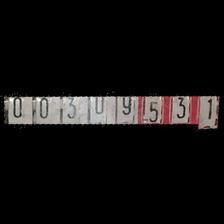

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


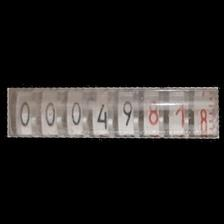

Predicted Labels for Segments: 1 1 1 7 1 2 1 1


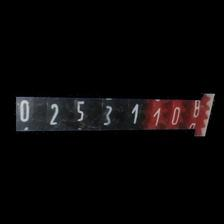

Predicted Labels for Segments: 1 1 1 1 1 9 9 1


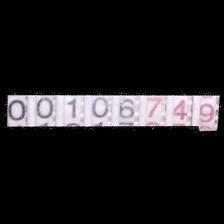

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


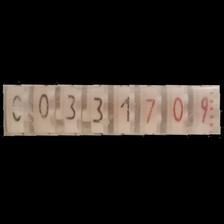

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


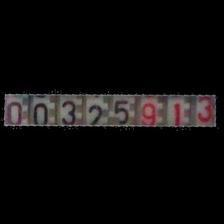

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


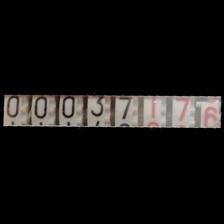

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


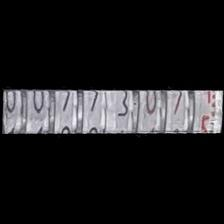

Predicted Labels for Segments: 1 1 3 1 8 2 2 2


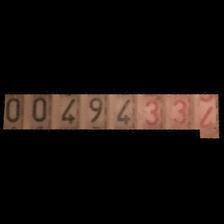

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


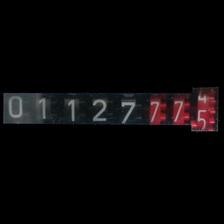

Predicted Labels for Segments: 1 1 1 10 10 1 1 2


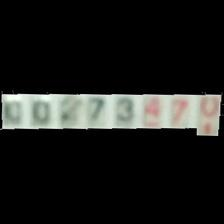

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


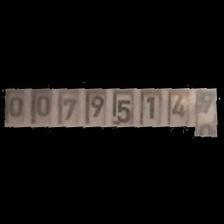

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


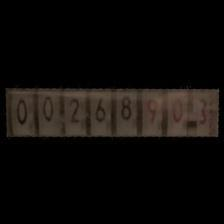

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


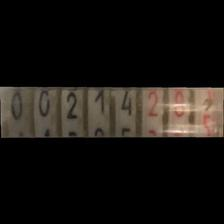

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


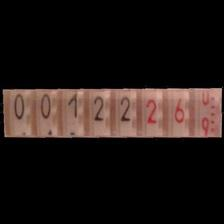

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


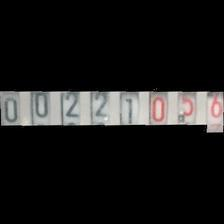

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


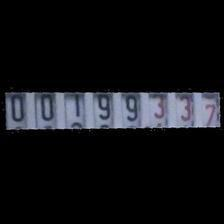

Predicted Labels for Segments: 1 1 1 1 1 1 1 8


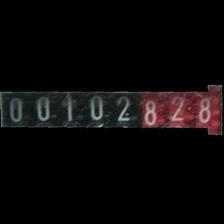

Predicted Labels for Segments: 1 8 1 1 1 1 1 1


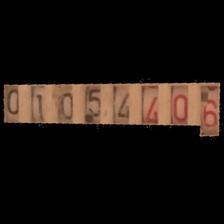

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


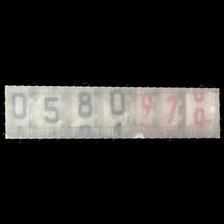

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


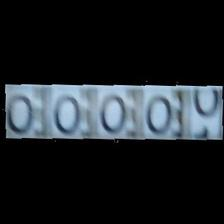

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


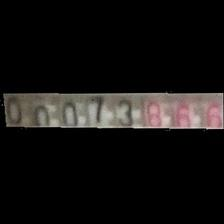

Predicted Labels for Segments: 1 1 1 7 1 1 1 1


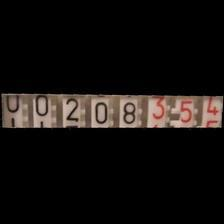

Predicted Labels for Segments: 1 1 1 1 1 1 1 1


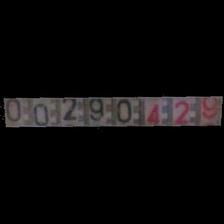

Predicted Labels for Segments: 1 1 1 1 1 1


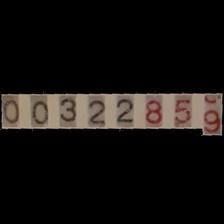

Predicted Labels for Segments: 


In [91]:
from google.colab.patches import cv2_imshow

# Assuming you have the image filenames and their corresponding predictions in a list
image_filenames = [image_info["file_name"] for image_info in annotation_data["images"]]

# Load the original images from the file system or wherever they are stored
original_images = [cv2.imread(os.path.join(image_folder, filename)) for filename in image_filenames]

# Iterate through each image
for image, filename in zip(original_images, image_filenames):
    # Display the original image
    cv2_imshow(image)

    # Find the corresponding prediction for this image by matching filenames
    image_id = [image_info["id"] for image_info in annotation_data["images"] if image_info["file_name"] == filename][0]
    predictions = [str(pred) for pred in y_test_pred[image_id * 8 : (image_id + 1) * 8]]

    # Display all the predicted labels for segments in the image as a single string
    predicted_labels_string = "Predicted Labels for Segments: " + " ".join(predictions)
    print(predicted_labels_string)

    # Press any key to proceed to the next image
    cv2.waitKey(0)
    cv2.destroyAllWindows()
